In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import DBSCAN,KMeans
import pandas as pd
import Lorentz
from tqdm import tqdm
import TSProcessor_learning_final
from sklearn.metrics import mean_squared_error,balanced_accuracy_score,accuracy_score
from sklearn.model_selection import train_test_split
%load_ext autoreload
%autoreload 2

In [2]:
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

def denormalize(arr, min, max):
    return arr * (max - min) + min

In [3]:
ser_energy = []
for x in open('energy_in_germany.txt').read().split(','):
    if x != '':
        ser_energy.append(float(x))

In [4]:
x = np.array(ser_energy)
x = normalize(x)[256:]

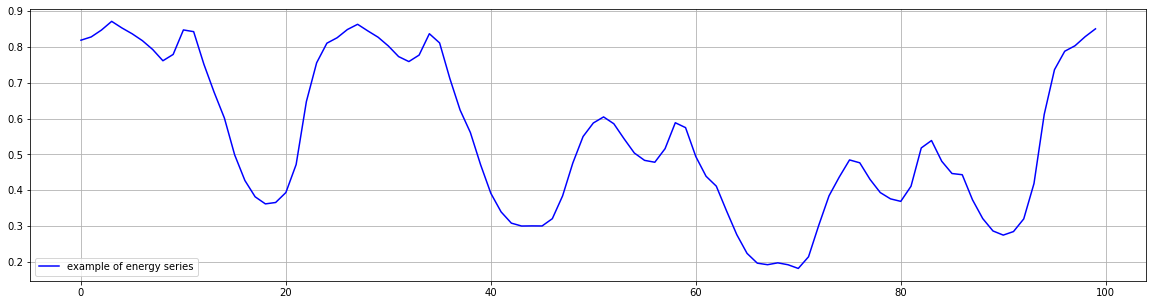

In [5]:
plt.figure(figsize=[20, 5])
plt.grid()
plt.plot(range(len(x[10000:10000+100])), x[10000:10000+100], c='blue',label='example of energy series')
plt.legend()
plt.show()

In [6]:
tsp = TSProcessor_learning_final.TSProcessor(4, 10)

In [7]:
split = 9000
steps = 100
eps   = 0.01
tsp.fit(x[:split])
forecast_sets = tsp.pull_traj_clust(steps=steps, eps=eps, n_trajectories=10, noise_amp=0.05,threshold=0.8)

100%|██████████| 10/10 [05:05<00:00, 30.59s/it]


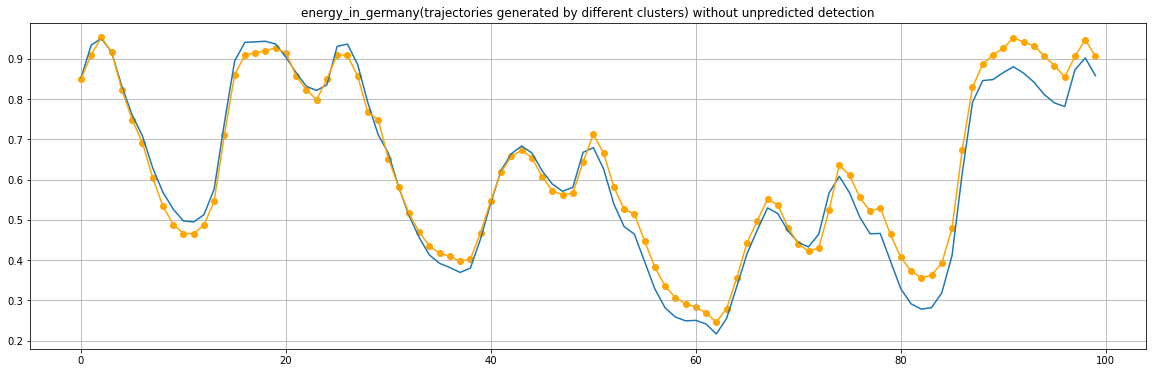

In [8]:
result = tsp.cluster_sets(forecast_sets, 0.01,5,smooth=False)

plt.figure(figsize=[20, 6])
plt.grid()
plt.plot(x[split:split + steps])

plt.scatter(range(result.size), result, c='orange')
plt.title("energy_in_germany(trajectories generated by different clusters) without unpredicted detection")
plt.plot(range(result.size), result, c='orange')

In [9]:
tsp.accumulate_train_set(forecast_sets,x[split:split+steps],0.05,0.1,5)
steps = 50
eps   = 0.01
for split in tqdm(range(9100,10100,100)):
    tsp.fit(x[:split])
    forecast_sets = tsp.pull_traj_clust(steps=steps, eps=eps, n_trajectories=10, noise_amp=0.05,threshold=0.8)
    tsp.accumulate_train_set(forecast_sets,x[split:split+steps],0.05,0.1,5)

100%|██████████| 10/10 [27:36<00:00, 165.61s/it]


In [11]:
train_df = tsp.get_train_set()

In [12]:
train_df['target'].value_counts()

1    450
0    150
Name: target, dtype: int64

In [13]:
tsp.learning_by_acc_set_gridCV(steps=50,kmeans_cl=30)

KMeans accuracy_score = 0.02736318407960199
KMeans accuracy_score = 0.40404040404040403
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ......bootstrap=True, max_depth=7, n_estimators=410; total time=   0.5s
[CV] END ......bootstrap=True, max_depth=7, n_estimators=410; total time=   0.5s
[CV] END ......bootstrap=True, max_depth=7, n_estimators=410; total time=   0.5s
[CV] END ......bootstrap=True, max_depth=7, n_estimators=100; total time=   0.1s
[CV] END ......bootstrap=True, max_depth=7, n_estimators=100; total time=   0.1s
[CV] END ......bootstrap=True, max_depth=7, n_estimators=100; total time=   0.1s
[CV] END .....bootstrap=True, max_depth=10, n_estimators=410; total time=   0.5s
[CV] END .....bootstrap=True, max_depth=10, n_estimators=410; total time=   0.5s
[CV] END .....bootstrap=True, max_depth=10, n_estimators=410; total time=   0.5s
[CV] END .....bootstrap=True, max_depth=10, n_estimators=100; total time=   0.1s
[CV] END .....bootstrap=True, max_depth=10

In [15]:
steps = 50
eps   = 0.01
pred_without_detect = dict()
pred_with_detect = dict()
true_value = dict()
for split in tqdm(range(10100,10600,100)):
    tsp.fit(x[:split])
    forecast_sets = tsp.pull_traj_clust(steps=steps, eps=eps, n_trajectories=10, noise_amp=0.05,threshold=0.8)
    pred_without_detect[split] = tsp.cluster_sets(forecast_sets, 0.01,5,smooth=False)
    pred_with_detect[split] = tsp.decider_by_forecast(forecast_sets,0.01,5,steps)
    true_value[split] = x[split:split + steps]

100%|██████████| 10/10 [02:59<00:00, 17.93s/it]
/Users/user/learning_temp/feat_pred/new_version_tsp/TSProcessor_v2/TSProcessor_learning_final.py:348: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  k_means = k_means.fit(pd_series)
 20%|██        | 1/5 [03:00<12:02, 180.57s/it]

Number of predicted points = 50.0



 40%|████      | 2/5 [06:18<09:17, 185.70s/it]

Number of predicted points = 44.0



100%|██████████| 10/10 [03:19<00:00, 19.94s/it]
/Users/user/learning_temp/feat_pred/new_version_tsp/TSProcessor_v2/TSProcessor_learning_final.py:348: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  k_means = k_means.fit(pd_series)
 60%|██████    | 3/5 [09:39<06:20, 190.28s/it]

Number of predicted points = 50.0



100%|██████████| 10/10 [03:21<00:00, 20.18s/it]
/Users/user/learning_temp/feat_pred/new_version_tsp/TSProcessor_v2/TSProcessor_learning_final.py:348: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  k_means = k_means.fit(pd_series)
 80%|████████  | 4/5 [13:02<03:14, 194.23s/it]

Number of predicted points = 46.0



100%|██████████| 5/5 [16:26<00:00, 197.26s/it]

Number of predicted points = 24.0


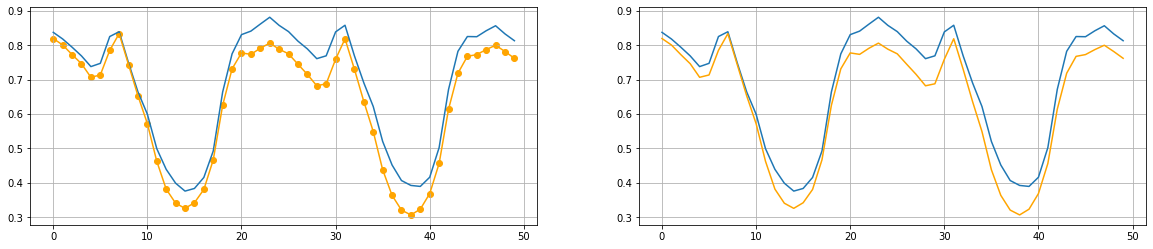

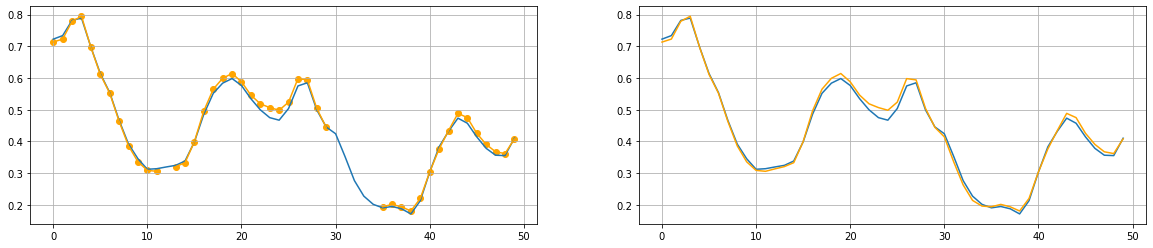

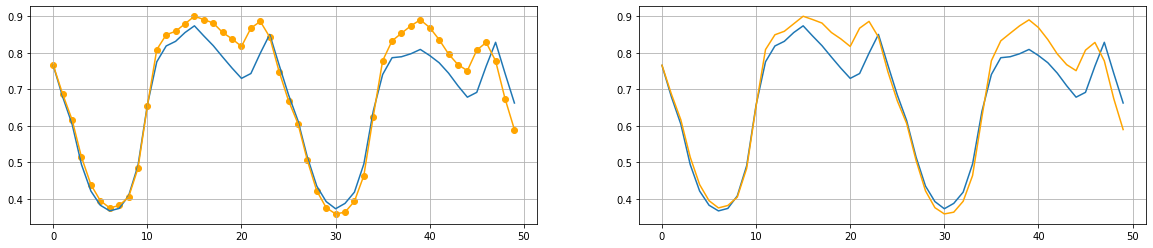

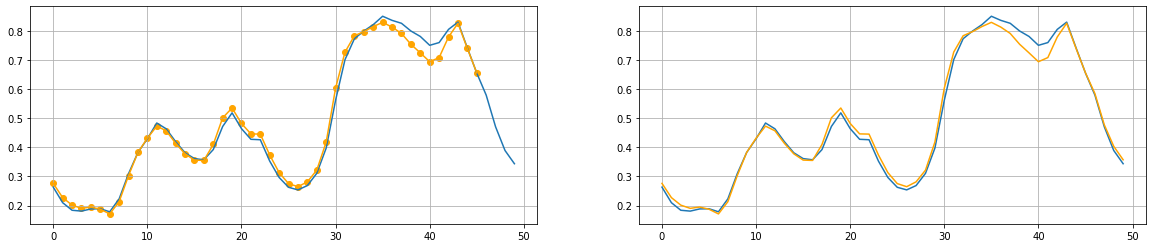

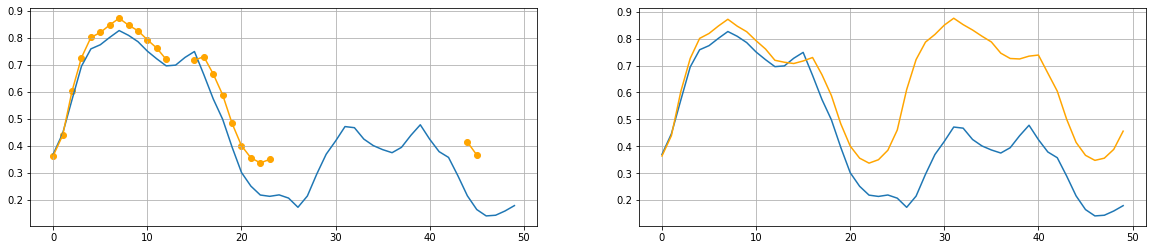

In [16]:
for split in range(10100,10600,100):
    fig, axes = plt.subplots(1, 2, figsize=(20, 4))
    axes[0].plot(true_value[split])
    axes[0].scatter(range(len(pred_with_detect[split])), pred_with_detect[split], c='orange')
    axes[0].plot(range(len(pred_with_detect[split])), pred_with_detect[split], c='orange')
    axes[1].plot(true_value[split])
    axes[1].plot(range(len(pred_without_detect[split])), pred_without_detect[split], c='orange')
    axes[0].grid()
    axes[1].grid()
    plt.show()

In [17]:
pred_per_int_corrected = dict()
for split,values in pred_with_detect.items():
    pred_per_int_corrected[split] = []
    for i in range(len(values)):
        if np.isnan(values[i]):
            pred_per_int_corrected[split].append(true_value[split][i])
        else:
            pred_per_int_corrected[split].append(values[i])

In [18]:
mean_square_aver_or = []
num_of_pred_aver_or = []
for i in range(1,steps):
    mean_square = []
    num_of_pred = []
    for split,values in pred_with_detect.items():
        mean_square.append(mean_squared_error(pred_per_int_corrected[split][:i],true_value[split][:i]))
        num_of_pred.append(sum(np.isnan(pred_with_detect[split][:i]))*100/i)
    mean_square_aver_or.append(np.mean(mean_square))
    num_of_pred_aver_or.append(np.mean(num_of_pred))

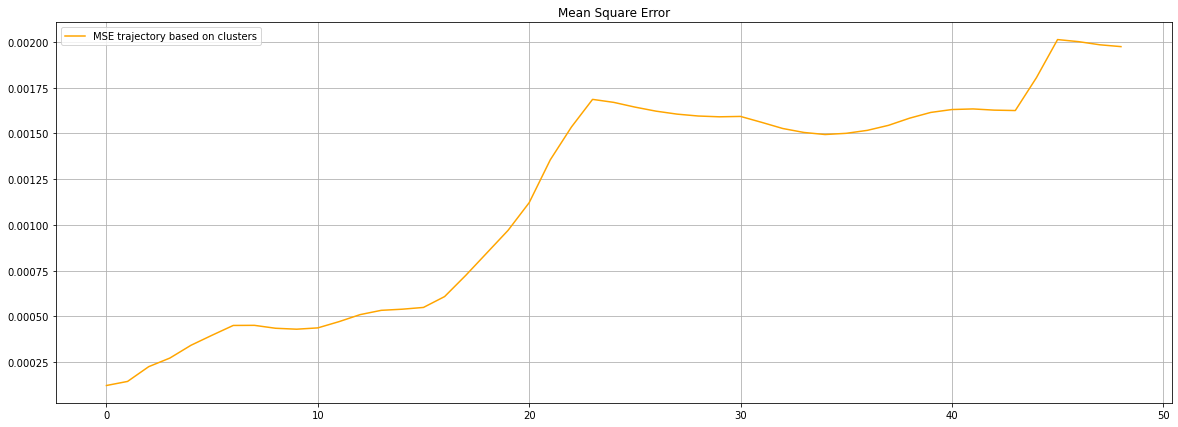

In [19]:
plt.figure(figsize=[20, 7])
plt.grid()
plt.plot(range(len(mean_square_aver_or)), mean_square_aver_or, c='orange',label='MSE trajectory based on clusters')
plt.legend()
plt.title('Mean Square Error')
plt.show()

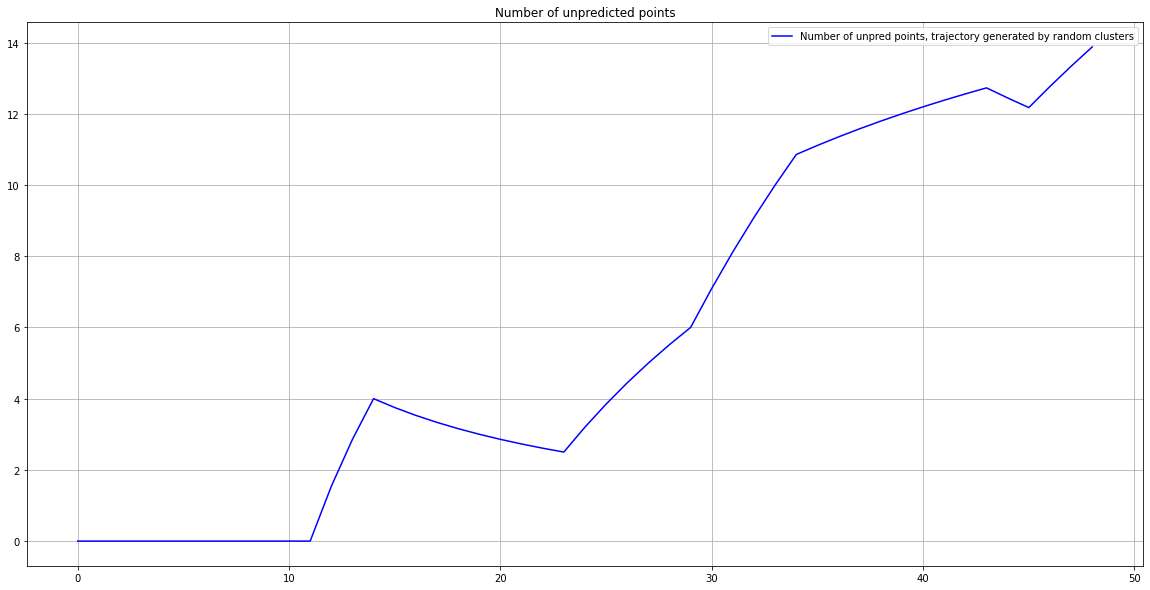

In [20]:

plt.figure(figsize=[20, 10])
plt.grid()
plt.plot(range(len(num_of_pred_aver_or)), num_of_pred_aver_or, c='blue',label='Number of unpred points, trajectory generated by random clusters')
plt.title('Number of unpredicted points')
plt.legend()
plt.show()